In [22]:
%load_ext autoreload
%load_ext google.cloud.bigquery
%autoreload 2

import sys
import json
from pathlib import Path

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from dotenv import find_dotenv, load_dotenv

from src.data.get_dataset import Dataset
from src.features import build_features
from src.visualization import visualize
from src.data import preprocess, utils

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows = 1000 # this will set limit of columns to 500
pd.options.display.max_columns = 1000 
random_state = 1234
load_dotenv(find_dotenv())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


True

## Get Admin Service & Tokopedia Loan Dataset 

In [2]:
dataset = Dataset()
train_data, test_data = dataset.get_dataset()

dataset = train_data
print(dataset.shape)

2018-11-13 07:37:06,437 [get_dataset.py:138 - get_admin_service_data() ]  INFO     Use cache for admin service data
2018-11-13 07:37:06,481 [get_dataset.py:271 - get_tokopedia_loan_data() ]  INFO     Use cache for tokopedia loan proposals data
2018-11-13 07:37:06,892 [preprocess.py:163 -    clean_tokped_data() ]  INFO     Tokopedia data cleaning started
2018-11-13 07:37:07,325 [preprocess.py:85 - parallel_get_missing_open_since() ]  INFO     using crawled caches
2018-11-13 07:37:07,341 [preprocess.py:99 - fill_missing_open_since() ]  INFO     fill missing open since
2018-11-13 07:37:07,413 [preprocess.py:188 -    clean_tokped_data() ]  INFO     Tokopedia data cleaning completed
2018-11-13 07:37:07,426 [preprocess.py:196 -   clean_pefindo_data() ]  INFO     Pefindo data cleaning started
2018-11-13 07:37:07,541 [preprocess.py:205 -   clean_pefindo_data() ]  INFO     Pefindo data cleaning completed
2018-11-13 07:37:07,547 [get_dataset.py:289 -    get_clean_dataset() ]  INFO     Merge admi

## Get Scraping Dataset

In [16]:
query = """
SELECT
  SUBSTR(domain,27) as domain, domain as shop_domain, is_active, item_sold, product_count, responship, favorite_count,
  reputation.shop_score as reputation_shop_score, reputation.shop_score_map as reputation_shop_score_map,
  #rating
  rating.rating.rating_score as  rating_score,	rating.rating.total_review as rating_total_review, rating.rating.star_level as rating_star_level,
  [ rating.rating.detail[ ORDINAL(5)].total_review, 
    rating.rating.detail[ ORDINAL(4)].total_review, 
    rating.rating.detail[ ORDINAL(3)].total_review, 
    rating.rating.detail[ ORDINAL(2)].total_review, 
    rating.rating.detail[ ORDINAL(1)].total_review] as rating_total_review_array,
  [satisfaction.positive.d_1m,	satisfaction.positive.d_6m,	satisfaction.positive.d_12m] as satisfaction_positive,
  [satisfaction.neutral.d_1m ,	satisfaction.neutral.d_6m,	satisfaction.neutral.d_12m]  as satisfaction_neutral,
  [satisfaction.negative.d_1m,	satisfaction.negative.d_6m,	satisfaction.negative.d_12m] as satisfaction_negative,
  [IFNULL(speed.d_1m.rate, 0), IFNULL(speed.d_3m.rate, 0), IFNULL(speed.d_12m.rate,0)] as speed_rate ,
  [IFNULL(speed.d_1m.sum_speed, 0), IFNULL(speed.d_3m.sum_speed, 0), IFNULL(speed.d_12m.sum_speed,0)] as speed_sum_speed,
  [IFNULL(speed.d_1m.order_count, 0), IFNULL(speed.d_3m.order_count, 0), IFNULL(speed.d_12m.order_count,0)] as speed_order_count,
  transaction.has_transaction as transaction_has_transaction,
  [IFNULL(transaction.d_1m.count,0), IFNULL(transaction.d_3m.count,0) , IFNULL(transaction.d_12m.count,0) ] as transaction_count, 
  [IFNULL(transaction.d_1m.success_rate,0), IFNULL(transaction.d_3m.success_rate,0), IFNULL(transaction.d_12m.success_rate,0)] as transaction_success_rate
FROM `credit_score.shop_data` 
"""
scraping_df = utils.query_from_biggquery(query)
print(scraping_df.shape)

2018-11-13 08:05:14,195 [utils.py:68 - query_from_biggquery() ]  INFO     Making bigquery connection
2018-11-13 08:06:00,902 [utils.py:83 - query_from_biggquery() ]  INFO     Query completed


In [51]:
data_path = '../data/raw'
scraping_df.to_csv('%s/scraping_robin.csv' % ( data_path), index=False)
!ls $data_path

loan_default.csv  scraping_robin.csv  tokopedia_loan_proposals.pkl


In [ ]:
#convert to float
float = ['reputation_shop_score', 'reputation_shop_map', 'rating_score ']

### Merge Clean Dataset with Scraping

In [18]:
data_merge = pd.merge(dataset, scraping_df, on='shop_domain', how='inner')

In [19]:
data_merge.shape

(1252, 75)

In [20]:
data_merge.head()

application_id credit_score  approved_amount  loan_id tenor  \
0           71004            B      5000000.000     3557    3m   
1           64793            B     50000000.000     2502    3m   
2             990            B     20000000.000      356   12m   
3           67712            B      7000000.000     3136    6m   
4           69795            B      6000000.000     3336    3m   

   max_unpaid_percentage  days_late  interest_rate     status  paid  unpaid  \
0                    nan        nan          0.013     closed 1.000   0.000   
1                    nan        nan          0.013     closed 3.000   0.000   
2                 65.988    507.000          0.013  disbursed 4.000   8.000   
3                    nan        nan          0.013  disbursed 3.000   0.000   
4                    nan        nan          0.013     closed 2.000   0.000   

   default  loan_amount  loan_duration program_name  complaint_count  \
0        0      5000000              3  Preapproved                0   
1        0     50000000              3  Preapproved                0   
2        1     25000000             12    Dana Tara               67   
3        0      7000000              6  Preapproved                0   
4        0      6000000              3  Preapproved                0   

           create_time                                   cashflow_history  \
0  2018-08-15 12:57:53  [4230000, 5210000, 4052800, 5295900, 3497300, ...   
1  2018-04-19 11:09:52  [68090000, 52395000, 92910000, 99094000, 62669...   
2  2017-01-13 17:51:18  [18478360, 15855150, 23993720, 27990450, 36963...   
3  2018-07-03 01:31:29  [11008500, 29452500, 23386000, 23007500, 15434...   
4  2018-07-30 12:02:53  [6055000, 8555000, 6880000, 6240000, 9200000, ...   

                                 transaction_history  ktp  npwp  \
0   [32, 39, 31, 32, 23, 24, 20, 36, 30, 17, 14, 19]    1     1   
1      [32, 28, 38, 52, 34, 31, 13, 13, 13, 2, 0, 0]    1     1   
2  [122, 97, 179, 156, 180, 219, 200, 119, 148, 1...    1     0   
3  [50, 130, 109, 96, 82, 96, 106, 105, 79, 125, ...    1     1   
4   [29, 41, 33, 27, 39, 35, 25, 29, 33, 55, 63, 48]    1     1   

   bank_statement  verificationPhoto          npwp_no gender marital_status  \
0               0                  1  838678555645000      m  Belum Menikah   
1               1                  1              NaN      m        Menikah   
2               0                  1              NaN      f    unspecified   
3               1                  1              NaN      m        Menikah   
4               1                  1  849839220421000      m  Belum Menikah   

  date_of_birth  successful_rate  face_match  negative     merchant_type  \
0          1993            0.981      70.711         9     Gold Merchant   
1          1974            1.000      72.843         0     Gold Merchant   
2          1990            1.000         nan        30  Regular Merchant   
3          1989            1.000       0.000        16  Regular Merchant   
4          1990            0.991      71.086         0  Regular Merchant   

      open_since       shop_type      date_start  \
0  November 2016    Hanya Online             NaN   
1       May 2017  Ada Toko Fisik             NaN   
2    August 2015    Hanya Online  1-Agustus-2015   
3   October 2015  Ada Toko Fisik             NaN   
4   January 2017    Hanya Online             NaN   

                              shop_domain            shop_name  \
0    https://www.tokopedia.com/aufa22shop          Aufa22 Shop   
1     https://www.tokopedia.com/angkasa5b   ANGKASA ELECTRONIC   
2    https://www.tokopedia.com/nandastore  Nanda Store Jakarta   
3  https://www.tokopedia.com/dhikavespacc              VespAcc   
4    https://www.tokopedia.com/diybattery  baterai android mod   

   confidence_address                     city  shopee_user  bukalapak_user  \
0               0.000       Kabupaten Lamongan            0               0   
1               0.000           

# Summary

## product_count

In [27]:
data_merge.product_count.describe()

count    1252.000
mean      615.280
std      2297.742
min         0.000
25%        40.000
50%       131.000
75%       411.250
max     54427.000
Name: product_count, dtype: float64

In [28]:
data_merge[data_merge.product_count == 0]

application_id credit_score  approved_amount  loan_id tenor  \
12              8088            B      5000000.000      465   12m   
49             63874            C      7000000.000     2228   12m   
62              2765            B      3000000.000      747   12m   
76              6415            B     50000000.000      694   12m   
80              6783            B     25000000.000      926   12m   
81              5902            B      7000000.000      587   12m   
108            66832            C      2000000.000     2970    6m   
125            61986            C     25000000.000     1648   12m   
131             9815            C     20000000.000     1443   12m   
146             8622            B      5000000.000     1254   12m   
182             1335            B      8000000.000     1065    6m   
210            61883            B    100000000.000     1606   12m   
211             7667            B     30000000.000      317   12m   
296             8150            B     25000000.000      692   12m   
297            64641            A     40000000.000     2453   12m   
313             8987            B     40000000.000      321   12m   
357             9575            C      8000000.000     1361    6m   
381            67932            C      5000000.000     3181    6m   
392            63401            B     30000000.000     2091    6m   
404              455            B      2000000.000       23    6m   
405             8400            B     15000000.000      149   12m   
407             7134            B      6000000.000     1098   12m   
419            63987            B      4000000.000     2244    6m   
423            62307            B     70000000.000     1791   12m   
424             4191            B     25000000.000     1118   12m   
474             2872            B      3000000.000      845    6m   
477            62122            C      8000000.000     1749   12m   
541             2187            B      5000000.000     1310   12m   
544            63170            C      6000000.000     2053   12m   
546            66714            B     10000000.000     2982    6m   
563            64898            C      5000000.000     2545    6m   
572             5011            B     10000000.000      640   12m   
578             2563            B     10000000.000      404   12m   
620            62255            C      5000000.000     1782   12m   
621            62179            C      5000000.000     1772   12m   
623             9170            B      8000000.000      118   12m   
656            64354            B      5000000.000     2347   12m   
657             7844            B      5000000.000      809   12m   
710            65526            C     10000000.000     2693   12m   
750            65969            C     25000000.000     2815   12m   
764            64717            C    100000000.000     2523   12m   
765            67769            C      5000000.000     3149   12m   
801            65153            C      5000000.000     2597   12m   
827            67072            B     15000000.000     3037   12m   
828            10057            C     10000000.000     1529    6m   
850            62768            C     20000000.000     1939   12m   
851            69658            C     40000000.000     3339   12m   
868            62386            C     30000000.000     1816   12m   
870             2703            B     10000000.000      388   12m   
894             3606            B     20000000.000      568   12m   
902             6125            B     15000000.000      936   12m   
905             9922            C      4000000.000     1481   12m   
906              414            B      4000000.000      187   12m   
917             8699            B      5000000.000      739    6m   
925            62103            C     10000000.000     1743   12m   
940            69818            C      7000000.000     3346    6m   
1002           64395            C      5000000.000     2384   12m   
1008

## item_sold

In [25]:
data_merge.item_sold.describe()

count      1252.000
mean      22269.448
std       82829.402
min          57.000
25%        1280.750
50%        3504.500
75%       11695.500
max     1418725.000
Name: item_sold, dtype: float64

2018-11-13 09:18:19,399 [_base.py:2491 - _update_title_position() ]  DEBUG    update_title_pos
2018-11-13 09:18:19,448 [font_manager.py:1251 -     _findfont_cached() ]  DEBUG    findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.5/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-13 09:18:19,528 [_base.py:2491 - _update_title_position() ]  DEBUG    update_title_pos
2018-11-13 09:18:19,605 [_base.py:2491 - _update_title_position() ]  DEBUG    update_title_pos
2018-11-13 09:18:19,666 [_base.py:2491 - _update_title_position() ]  DEBUG    update_title_pos
2018-11-13 09:18:19,703 [_base.py:2491 - _update_title_position() ]  DEBUG    update_title_pos


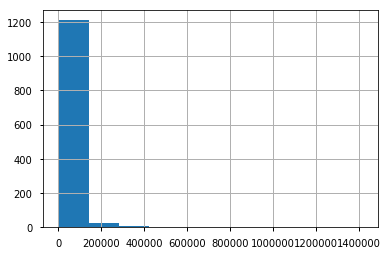

In [24]:
data_merge.item_sold.hist()

## responship

In [40]:
# ???
data_merge.responship.describe()

count   1252.000
mean      14.002
std       26.100
min       -1.000
25%        1.000
50%        5.000
75%       19.000
max      441.000
Name: responship, dtype: float64

## favorite_count

In [29]:
data_merge.favorite_count.describe()

count    1252.000
mean      698.076
std      2478.138
min         0.000
25%        34.000
50%       169.000
75%       503.250
max     36968.000
Name: favorite_count, dtype: float64

## reputation_shop_score

In [30]:
data_merge.reputation_shop_score.describe()

count       1252
unique      1000
top       98.332
freq           6
Name: reputation_shop_score, dtype: object

## reputation_shop_score_map

In [32]:
data_merge.reputation_shop_score_map.value_counts()

9     295
11    247
7     165
10    154
8     144
6      70
12     66
13     47
14     21
5      19
16     16
17      2
19      2
15      1
4       1
18      1
0       1
Name: reputation_shop_score_map, dtype: int64

## rating_score

In [34]:
data_merge.rating_score.value_counts()

4.6    253
4.7    250
4.8    213
4.5    141
4.4    132
4.9    105
4.3     68
4.1     38
4.2     27
4.0     11
5.0     10
3.7      1
3.6      1
3.8      1
3.9      1
Name: rating_score, dtype: int64

## rating_total_review

In [35]:
data_merge.rating_total_review.describe()

count     1252.000
mean      2752.439
std       7105.011
min         26.000
25%        432.500
50%        985.000
75%       2410.750
max     111371.000
Name: rating_total_review, dtype: float64

## rating_star_level

In [36]:
data_merge.rating_star_level.describe()

count   1252.000
mean       4.734
std        0.442
min        4.000
25%        4.000
50%        5.000
75%        5.000
max        5.000
Name: rating_star_level, dtype: float64

## transaction_has_transaction

In [38]:
data_merge.transaction_has_transaction.value_counts()

1    1252
Name: transaction_has_transaction, dtype: int64